In [1]:
import numpy as np        
import matplotlib.pyplot as plt
%matplotlib inline

from src.mnist import load_mnist_data # Pegar todos os dados dos digitos MNIST como binário, e transformar para np.array
from src.Model import Model # Classe custom Modelo Deep
from PIL import Image   # Manipulação de Pixels

!pip install requests

### Treinando o Modelo da Classe *Model*. 
#### Esse modelo vem um classe custom da class *Model*, o qual é utilizado apenas numpy na sua implementação
#### Vamos treinar para reconhecer o digits do data set MNIST, com seguintes configurações:
#### - **2** hidden layers de **128** dimensões
#### - **0.035** learning rate
#### - **sigmoid** activation, em todas as camadas 
#### - **MSE** função custo
#### - **2** épocas (pode botar mais se quiser, mas com 2 já trás uma boa acurácia), cada epoca passa por **42 mil** exemplos dos dados de treinamento

## Comentários sobre treinamento:
##### Houve experimentos anteriores, utilizando, duas (ou mais, porém esses demorariam muito na minha máquina) hidden layers de 64 dimensões, outra vez com 16 dimensões, e por fim 48.

Á priori, percebi com sigmoid 64 para 128 dimensões sempre achava um caminho que aprendia rápido o suficiente, com 50 épocas com lr = 0.035 
rapidamente chegava a 92% acurácia, e com mais algumas épocas chegava a 97% (*com dados de treinamento*). 

Porém eu temo que com tantas dimensões pode ocorrer de se especializar demais, eu penso nisso, porque mais lá pra baixo nesse notebook, existe uma sessão onde podemos assistir o que o modelo advinha com um exemplo *custom* de uma imagem 28x28 de um digito criada por mim no app **microsoft paint**, e nesse casos, com 128 dimensões, ele erra coisas que um modelo de 16 dimensões, não erraria, apesar do modelo de 16 ter uma acurácia menor (91%), me pareceu generalizar melhor. 
Eu imagino que com menos dimensões na camada escondida o Modelo é forçado a entender o que é mais importante, ao invez de "manter em mente" caracteristicas especificas dos dados de treinamento.

Além disso, os modelos com mais camadas de pequenas dimensões, demoraram  muito para aumentar acurácia, exemplo:
Modelo de:
	- 3 hidden layer de dimensões na sequencia (20,16,20)
	- *tangente hiperbolica* ("tanh") activation, em todas as camadas
	- lr = 0.02
	- MSE, custo
	- 500 épocas de 40 mil exemplos
Esse modelo chegou a uma acurácia de 88%, muito inferior tanto em velocidade de treinamento, e acertos.
Mas, esse modelo de tanh, ele teve uma generalização decente, chegando a ser parecido com o Modelo que vamos usar (2 hidden de 128 dim).
Claro que foi só eu desenhando no paint e testando, mas te faz questionar um pouco se esse modelo continuasse treinando, ele teria uma generalização melhor?

In [2]:

# traning_data, foi os 42 mil usados pelo modelo.
# dimensions, as dimensões usadas para treinamentodo modelo (784,128,128,10)
all_data = load_mnist_data()
split = 42000

normalize_term = np.amax(all_data["inputs" ])

print("Normalizing Term:",	normalize_term)
print("Quantidade de exemplos:",	len(all_data["inputs"]))
print("Dimensão da imagem: ",		len(all_data["inputs"][0]))
print("Quantidade de digitos: ",	len(all_data["outputs"][0]))

# Treinamos com 42 mil exemplos
train_data = {
	"inputs" :	all_data["inputs" ][:split]/normalize_term,
	"outputs":	all_data["outputs"][:split]
}

# Restante dos 28 mil exemplos que o modelo não viu, será nossos dados de teste
test_data = {
	"inputs" :	all_data["inputs" ][split:]/normalize_term,
	"outputs":	all_data["outputs"][split:]
}

test_data_being_used = test_data

Normalizing Term: 255
Quantidade de exemplos: 70000
Dimensão da imagem:  784
Quantidade de digitos:  10


## Treinando Modelo

In [3]:
# Modelo com configurações mencionada anteriormente
#model  = Model((784,128,128,10), activation="sigmoid", verbose=0, wr=(-0.5,0.5))
"""Caso queira começar do zero, comente a proxima linha e descomente a linha anterior"""
model  = Model.load("./models/model_128x128")


In [4]:
"""É possivel repetir essa celula diversas vezes para treinar o modelo, com epochs, our learning rate diferentes"""
learning_rate = 0.035
# Fique a vontade pra trocar aumentar as épocas, sei que com 50 chega a 98% acurácia
epochs = 0
model_filename = "model_128x128"

print("\n> Model Started Training...\n")
			
model.train(
	train_data["inputs"],
	train_data["outputs"],
	lr = learning_rate, epochs=epochs,
	shuffle=True,
	autosave=False)
	
# Caso já tenha um modelo salvo, dê load assim
#model = Model.load("./models/" + model_filename)

print("> Done.")
print(f"{np.std(train_data['inputs'])=}")



> Model Started Training...

> Done.
np.std(train_data['inputs'])=0.30871470959787384


/*==================================================*/
X  (input) layer:
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0. 

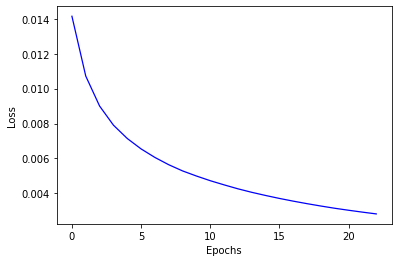

> model saved in:  ./models/model_128x128
> model saved in:  model_128x128


In [5]:
model.print()

model.save("./models/" + model_filename)
print("> model saved in: ",model_filename)

### Função usada para fazer predições do set MNIST com o Modelo. 
*Ao usar **test_prediction** ira mostrar a **imagem**, o **label** correto, e a **decisão** do modelo*

In [6]:
def test_prediction(index, data, model:Model):
	current_image = data["inputs"][index]
	y_predict = model.predict(current_image)[0]
	prediction = (y_predict == y_predict.max()).astype(int)

	guess = list(prediction).index(1)
	
	label = data["outputs"][index]
	ground_truth = list(label).index(1)

	# Opção de desobrigar de fornecer label correto, para quando formor utilizar paint
	if len(label) < 10:
		label = "made on paint"
		ground_truth = " paint"

	print("Label: ", label)
	print("Prediction: ", prediction)

	plt.gray()
	plt.title("Model thinks it is: " + str(guess) + "\nGround truth: " + str(ground_truth))
	plt.imshow( current_image.reshape((28, 28)) * 255, interpolation='nearest')
	plt.xticks([])
	plt.yticks([0])
	plt.show()

## Função p/ testar a acurácia dos restante 28 mil digitos que o modelo não viu ainda
### e ainda retorna todos os indices errados

In [7]:
def get_acurracy(testing_data):
	
	predicts = list()
	for y in testing_data["inputs"]:
		y_predict = model.predict(y)[0]
		prediction = (y_predict == y_predict.max()).astype(int)
		predicts.append(prediction)
	return model.accuracy(predictions=predicts, outputs=testing_data["outputs"], verbose=0)


## Array de indices onde o modelo errou
#### Acurácia: cerca de **97%** usando 28 mil exemplos dos dados de teste os quais o modelo nunca viu

In [8]:
accuracy,wrong_indexes = get_acurracy(test_data_being_used)

print( "Qntd de exemplos:",len(test_data_being_used["inputs"]))
print(f"Indexes onde está errado: {wrong_indexes}\n")
print("Acurácia: ",accuracy,'\n' )

Qntd de exemplos: 28000
Indexes onde está errado: [20, 78, 112, 139, 181, 199, 255, 337, 364, 384, 415, 428, 434, 438, 491, 503, 504, 526, 566, 624, 671, 673, 782, 854, 892, 941, 953, 973, 986, 995, 1012, 1034, 1043, 1069, 1099, 1109, 1121, 1454, 1537, 1548, 1562, 1574, 1588, 1658, 1670, 1702, 1823, 1867, 1897, 1898, 1950, 1986, 2172, 2262, 2294, 2300, 2378, 2442, 2456, 2484, 2552, 2626, 2690, 2753, 2827, 2848, 2870, 2959, 2961, 2969, 3005, 3043, 3114, 3116, 3117, 3143, 3185, 3238, 3274, 3352, 3422, 3439, 3458, 3502, 3509, 3520, 3530, 3532, 3575, 3615, 3616, 3692, 3749, 3761, 3801, 3813, 3868, 3875, 3901, 3954, 3968, 3982, 4015, 4033, 4078, 4088, 4122, 4146, 4238, 4241, 4247, 4248, 4269, 4284, 4285, 4288, 4298, 4314, 4368, 4373, 4404, 4406, 4412, 4435, 4689, 4709, 4726, 4736, 4776, 4815, 4857, 4860, 4895, 4906, 4938, 4941, 4965, 4976, 5034, 5094, 5132, 5152, 5217, 5220, 5227, 5234, 5247, 5264, 5317, 5376, 5421, 5443, 5471, 5475, 5479, 5560, 5597, 5600, 5689, 5690, 5718, 5737, 5759, 584

### Escolha um index no intervalo [0,28'000) Cerca de 97.9% vai estar certo
#### *A ideia é poder ver a imagem e a predição do modelo*

Label:  [0 1 0 0 0 0 0 0 0 0]
Prediction:  [0 1 0 0 0 0 0 0 0 0]


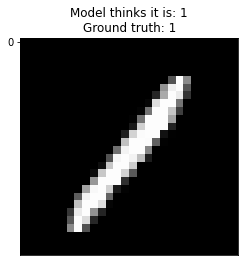

In [9]:
# Escolha um index no intervalo [0,2800'000) Cerca de 96% vai estar certo
index = 27049
test_prediction(index,test_data_being_used,model)

## Algumas das imagens que deram errado
#### *Apenas troque esses index e vejao exemplos em que o modelo errou*

Label:  [1 0 0 0 0 0 0 0 0 0]
Prediction:  [1 0 0 0 0 0 0 0 0 0]


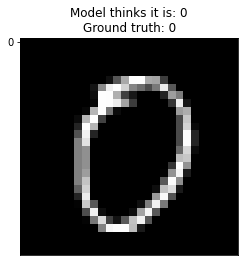

In [10]:
# Alguns dos indexes errados: 27749, 21073, 27839, 26522, 21558 (usando 28k testing_data)
index_errado = 21077
test_prediction(index_errado,test_data_being_used,model)

# Testaremos com novos dados gerando por desenhos no paint
### Essa função ajuda a pegar os pixels como np.array

In [11]:
def get_pixels(filename):
	im = Image.open(filename, "r")
	pixels = list(im.getdata())
	mono_channel_pixels = [rgb[2] for rgb in pixels[0:784]]
	return np.array(mono_channel_pixels)/255.0

## Agora **edite** o aquivo *digit28x28.png* no **paint** e **rode** a celula abaixo novamente para ir atualizando a predição do modelo
### Lembre de manter o formato 28x28

Label:  made on paint
Prediction:  [0 0 0 1 0 0 0 0 0 0]


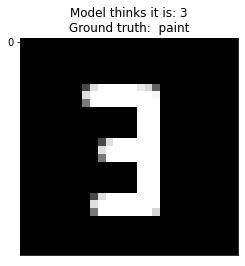

In [12]:
test_pixels = get_pixels("digit28x28.png")
test_prediction(0,{"inputs":[test_pixels],"outputs":[[1]]},model)
